In [1]:
# install tensorflow
import tensorflow as tf

# notebook to do a timeseries prediction on *nonlinear* data using RNN with LSTM

LSTM: long short-term memory

LSTM is like SimpleRNN and will show up as a layer within the RNN

In [2]:
# other imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
# make the function - square the input
series = np.sin((0.1*np.arange(400))**2)

this will be a timeseries of the form:
$$
x(t) = \text{sin}(\omega t^2)
$$
which is nonlinear! and harder to predict

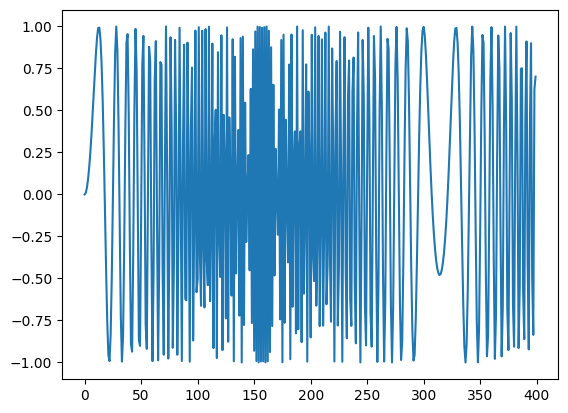

In [4]:
# plot the data
plt.plot(series)
plt.show()

In [5]:
# build the data - turning the problem into a supervised learning format 
# input: N x T x D, target: N
# we want to use T past values to predict the next value
T = 10
D = 1
X = []; Y = []

# we need to account for the data used to predict (10) and the target (1)
# so the final target index is len(series)-1, meaning t must go up to len(series)-T-1
for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

# cast lists to np arrays and print shape 
X = np.array(X).reshape(-1, T) # this needs to be N x T 
Y = np.array(Y)
N = len(X)
print('X.shape:', X.shape, 'Y.shape:', Y.shape)

X.shape: (390, 10) Y.shape: (390,)


In [7]:
# first, try an autoregressive linear model
# this shouldn't work given the nonlinear data
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i,x)
model.compile(loss = 'mse', optimizer=Adam(lr=0.01))

# train the AR RNN
r = model.fit(
    X[:-N//2], Y[:-N//2], 
    epochs=80, 
    validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/80
7/7 [==============================] - 1s 32ms/step - loss: 1.3997 - val_loss: 1.0487
Epoch 2/80
7/7 [==============================] - 0s 7ms/step - loss: 1.3761 - val_loss: 1.0417
Epoch 3/80
7/7 [==============================] - 0s 9ms/step - loss: 1.3559 - val_loss: 1.0346
Epoch 4/80
7/7 [==============================] - 0s 8ms/step - loss: 1.3345 - val_loss: 1.0267
Epoch 5/80
7/7 [==============================] - 0s 7ms/step - loss: 1.3141 - val_loss: 1.0189
Epoch 6/80
7/7 [==============================] - 0s 7ms/step - loss: 1.2932 - val_loss: 1.0116
Epoch 7/80
7/7 [==============================] - 0s 8ms/step - loss: 1.2745 - val_loss: 1.0031
Epoch 8/80
7/7 [==============================] - 0s 8ms/step - loss: 1.2567 - val_loss: 0.9912
Epoch 9/80
7/7 [==============================] - 0s 10ms/step - loss: 1.2380 - val_loss: 0.9803
Epoch 10/80
7/7 [==============================] - 0s 10ms/step - loss: 1.2184 - val_loss: 0.9704
Epoch 11/80
7/7 [===================

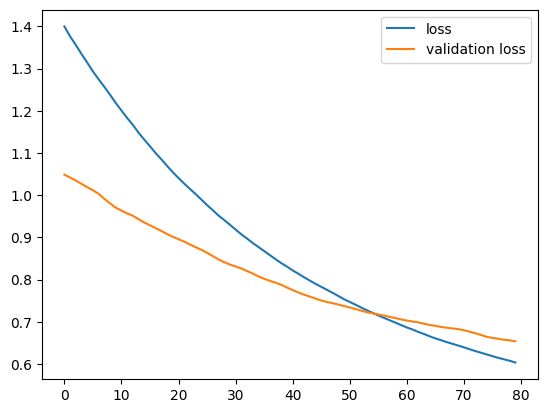

In [8]:
# plot loss per epoch
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

13/13 [==============================] - 0s 2ms/step
(390, 1)


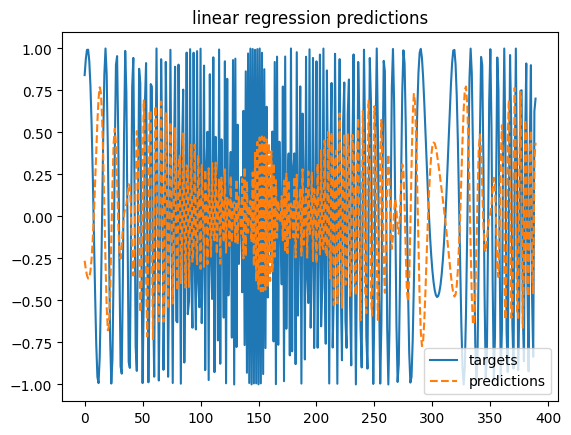

In [9]:
# try to do a one-step forecast using true targets
# this uses the whole dataset (X)
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

# plot
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions', linestyle='dashed')
plt.title('linear regression predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 26ms/step


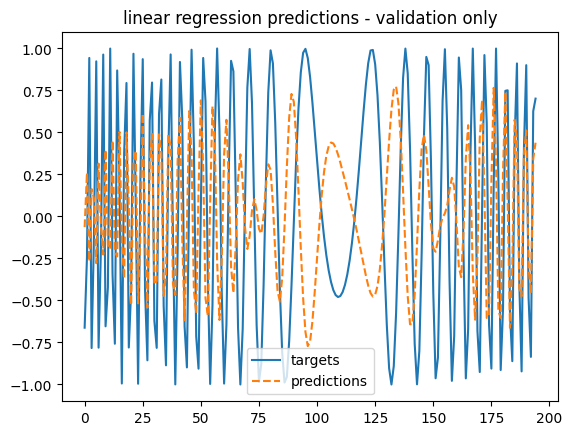

In [16]:
# can also try the one-step forecast with just the validation data 
validation_target = Y[-N//2:]
validation_predictions = []

# index of the first validation input
i = -N//2

# for RNN, what goes into model.predict needs to be 3D, which X is
# but if we index it, it'll be a scalar
# model.predict returns an NxK output, and here N and K = 1
while len(validation_predictions) < len(validation_target): 
  p = model.predict(X[i].reshape(1,-1))[0,0]    # 1x1 array > scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

# plot
plt.plot(validation_target, label='targets')
plt.plot(validation_predictions, label='predictions', linestyle='dashed')
plt.title('linear regression predictions - validation only')
plt.legend()
plt.show()

1/1 [==============================] - 0s 22ms/step


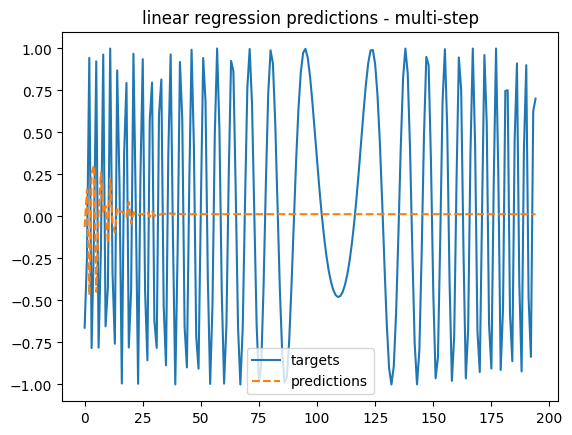

In [15]:
# multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last training input, will return a 1D array of length T
last_x = X[-N//2]

# the same process (keep the reshape)
while len(validation_predictions) < len(validation_target): 
  p = model.predict(last_x.reshape(1,-1))[0,0]    # 1x1 array > scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input - meaning we'll use the current prediction to make next prediction
  # so we'll shift all current values to the left and add the new prediction at the end
  # can do using np.roll()
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

# plot
plt.plot(validation_target, label='targets')
plt.plot(validation_predictions, label='predictions', linestyle='dashed')
plt.title('linear regression predictions - multi-step')
plt.legend()
plt.show()

so the linear model does a horrible job 

so let's try a simple RNN model

In [18]:
# simpleRNN model - need to reshape to be N x T x D
X = X.reshape(-1, T, 1)

# make the RNN
i = Input(shape=(T,D))
x = SimpleRNN(10)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.05))

# train RNN
r = model.fit(
    X[:-N//2], Y[:-N//2], 
    batch_size=32,
    epochs=200, 
    validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/200
7/7 [==============================] - 2s 52ms/step - loss: 0.5753 - val_loss: 0.5604
Epoch 2/200
7/7 [==============================] - 0s 15ms/step - loss: 0.4828 - val_loss: 0.6217
Epoch 3/200
7/7 [==============================] - 0s 11ms/step - loss: 0.5195 - val_loss: 0.5947
Epoch 4/200
7/7 [==============================] - 0s 12ms/step - loss: 0.4985 - val_loss: 0.5144
Epoch 5/200
7/7 [==============================] - 0s 16ms/step - loss: 0.4775 - val_loss: 0.5590
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 0.4439 - val_loss: 0.5265
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 0.4051 - val_loss: 0.4775
Epoch 8/200
7/7 [==============================] - 0s 11ms/step - loss: 0.4097 - val_loss: 0.5278
Epoch 9/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4101 - val_loss: 0.5641
Epoch 10/200
7/7 [==============================] - 0s 18ms/step - loss: 0.3619 - val_loss: 0.5579
Epoch 11/200
7/7 [=

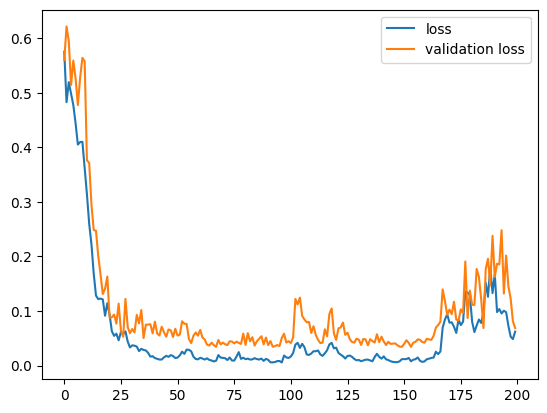

In [19]:
# plot loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

13/13 [==============================] - 0s 2ms/step
(390, 1)


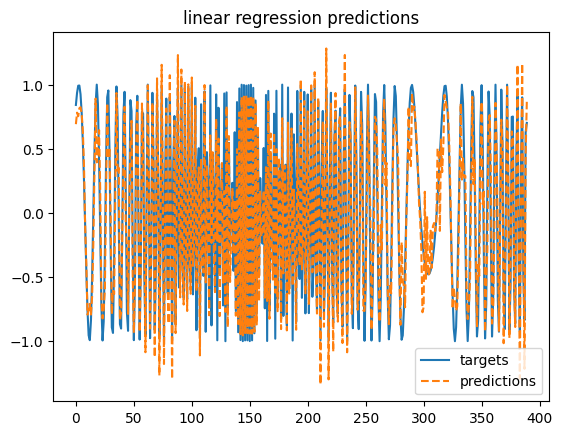

In [20]:
# one-step forecast using true targets (like before)
# this uses the whole dataset (X)
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

# plot
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions', linestyle='dashed')
plt.title('one-step RNN predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 25ms/step


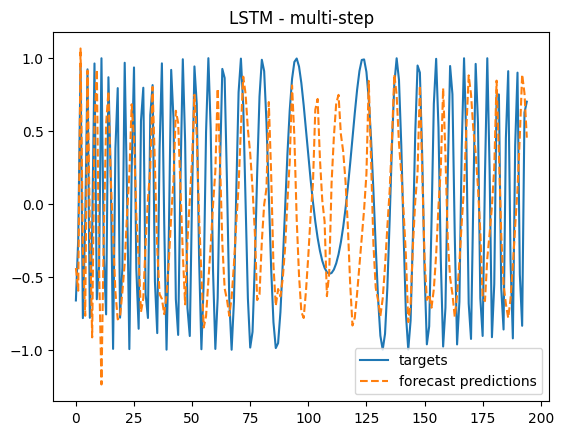

In [25]:
# multi-step forecast

# last training input, will return a 1D array of length T
input_ = X[-N//2]
forecast = []

# the same process 
while len(forecast) < len(Y[-N//2:]): 
  f = model.predict(input_.reshape(1,T,1))[0,0]    # reshape to N x T x D

  # update the predictions list
  forecast.append(f)

  # make the new input - meaning we'll use the current prediction to make next prediction
  # so we'll shift all current values to the left and add the new prediction at the end
  # can do using np.roll()
  input_ = np.roll(input_, -1)
  input_[-1] = f

# plot
plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast predictions', linestyle='dashed')
plt.title('multi-step RNN predictions')
plt.legend()
plt.show()

this still doesn't look good, but at the beginning the model
appears to capture the frequency

also - does a better job than AR model, so we're on the right track

let's try LSTM

In [29]:
# make the LSTM model
X = X.reshape(-1, T, 1)
i = Input(shape=(T,D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.05))

# train RNN
r = model.fit(
    X[:-N//2], Y[:-N//2], 
    batch_size=32,
    epochs=200, 
    validation_data=(X[-N//2:], Y[-N//2:])
)

Epoch 1/200
7/7 [==============================] - 4s 102ms/step - loss: 0.5240 - val_loss: 0.5355
Epoch 2/200
7/7 [==============================] - 0s 14ms/step - loss: 0.4711 - val_loss: 0.5372
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4279 - val_loss: 0.5483
Epoch 4/200
7/7 [==============================] - 0s 27ms/step - loss: 0.4282 - val_loss: 0.5709
Epoch 5/200
7/7 [==============================] - 0s 19ms/step - loss: 0.4091 - val_loss: 0.6459
Epoch 6/200
7/7 [==============================] - 0s 18ms/step - loss: 0.3714 - val_loss: 0.5356
Epoch 7/200
7/7 [==============================] - 0s 16ms/step - loss: 0.2593 - val_loss: 0.4786
Epoch 8/200
7/7 [==============================] - 0s 18ms/step - loss: 0.2552 - val_loss: 0.4112
Epoch 9/200
7/7 [==============================] - 0s 19ms/step - loss: 0.2238 - val_loss: 0.4282
Epoch 10/200
7/7 [==============================] - 0s 15ms/step - loss: 0.1672 - val_loss: 0.4132
Epoch 11/200
7/7 [

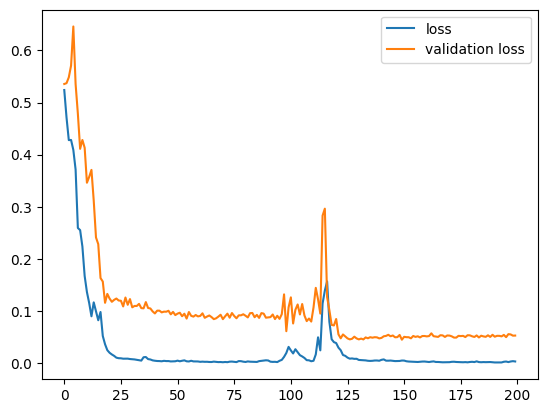

In [30]:
# plot loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

13/13 [==============================] - 0s 8ms/step
(390, 1)


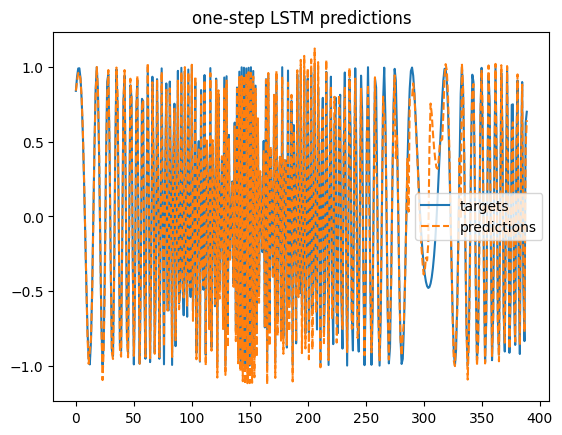

In [32]:
# one-step forecast using true targets (like before)
# this uses the whole dataset (X)
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

# plot
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions', linestyle='dashed')
plt.title('one-step LSTM predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 22ms/step


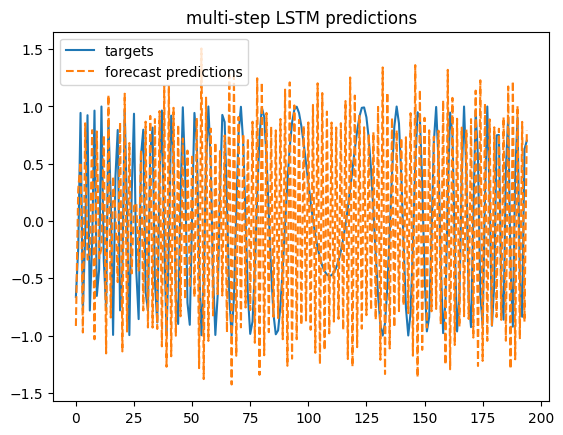

In [33]:
# multi-step forecast

# last training input, will return a 1D array of length T
input_ = X[-N//2]
forecast = []

# the same process 
while len(forecast) < len(Y[-N//2:]): 
  f = model.predict(input_.reshape(1,T,1))[0,0]    # reshape to N x T x D

  # update the predictions list
  forecast.append(f)

  # make the new input - meaning we'll use the current prediction to make next prediction
  # so we'll shift all current values to the left and add the new prediction at the end
  # can do using np.roll()
  input_ = np.roll(input_, -1)
  input_[-1] = f

# plot
plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast predictions', linestyle='dashed')
plt.title('multi-step LSTM predictions')
plt.legend()
plt.show()

still not great - cannot capture the lower frequency data

why? LSTM's are not necessarily more powerful or always have better accuracy compared to simple RNNs

LSTM's are better than simple RNNs at long-range forecasts, and this data doesn't really have that